In [ ]:

# N
# D blood vessel width, yellow dots, red dots
# G optic nerve size, optic disk size
# C blur
# A micropigments,yellow distortion/shade in the center
# H blood vessel width
# M blood vessel width, yellow dots, red dots, optic disk size

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage import exposure, util
from skimage.filters import unsharp_mask, threshold_multiotsu, sato, meijering, frangi, hessian
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray

def plot_image(img, title='', map=None):
  fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
  ax.imshow(img, cmap=map)
  ax.set_title(title)
  ax.axis('off')

def plot_hist_and_Channel(img, title='', map=None, bound=256):
  fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))
  ax0.hist(img.ravel(), 512, log=True, density=False)
  ax0.set_title(title+" histogram")
  ax0.set_xbound(0, bound)
  ax1.imshow(img, cmap=map)
  ax1.set_title(title+" image")
  ax1.axis('off')
  fig.tight_layout()


def plot_hist_and_Channel_3(img, title='', map=None, dtype=int):
  # extract Red channel
  r_img = img * [1, 0, 0]
  # extract Green channel
  g_img = img * [0, 1, 0]
  # extract Blue channel
  b_img = img * [0, 0, 1]
  upper_bound = 256
  if (dtype != int): upper_bound = 1.0
  plot_hist_and_Channel(r_img, 'R '+title, map=map, bound=upper_bound)
  plot_hist_and_Channel(g_img, 'G '+title, map=map, bound=upper_bound)
  plot_hist_and_Channel(b_img, 'B '+title, map=map, bound=upper_bound)

def extract_spectrum(img, low_thresh, upper_thresh, map=None, dtype=int):
  # set a threshold on the channel
  binary_img = np.where((img >= low_thresh) & (img <= upper_thresh), img, 0)

  fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))
  ax0.hist(img.ravel(), 512, log=True, density=False)
  ax0.set_title("Histogram of the channel")
  ax0.axvline(x=low_thresh,   color='r', linestyle='dashed', linewidth=1)
  ax0.axvline(x=upper_thresh, color='r', linestyle='dashed', linewidth=1)
  if (dtype == int): upper_bound = 255
  else: upper_bound = 1.0
  ax0.set_xbound(0, upper_bound)
  ax1.imshow(binary_img, cmap=map)
  ax1.set_title("Thresholded image")
  ax1.axis('off')
  fig.tight_layout()

  return binary_img


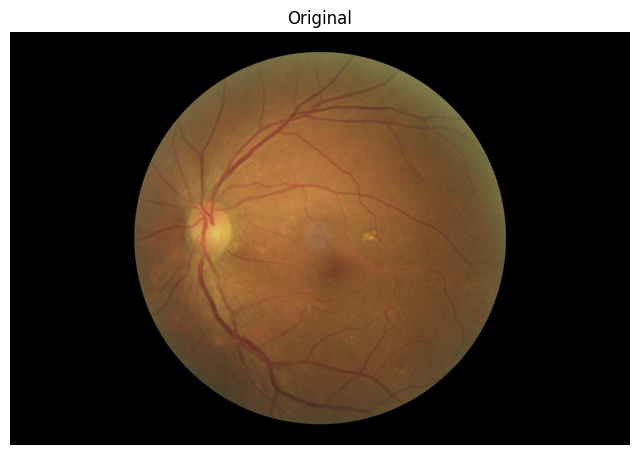

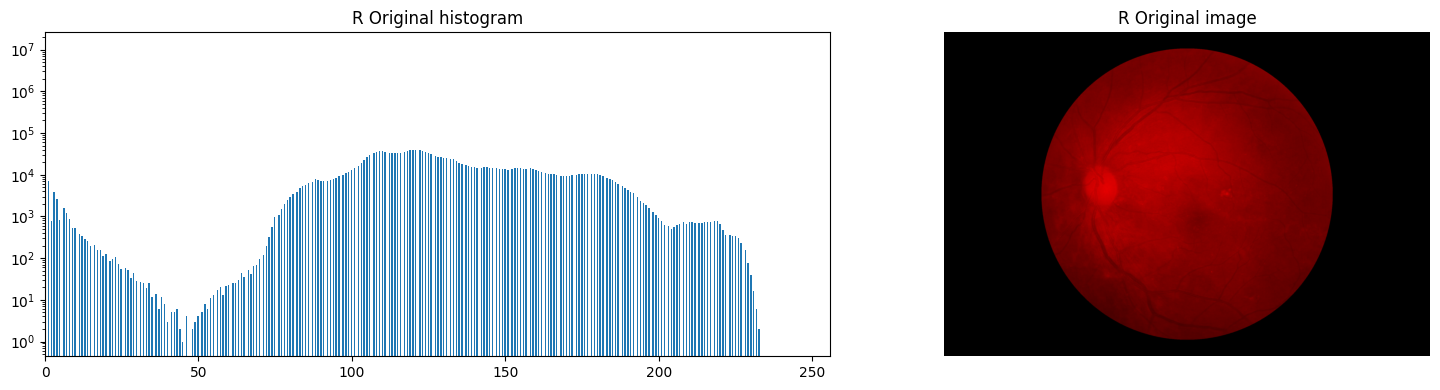

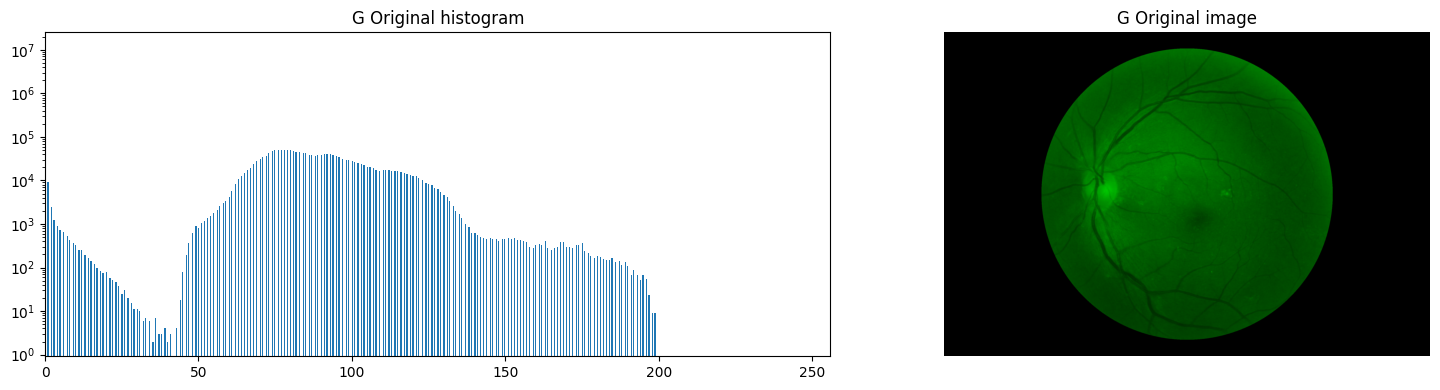

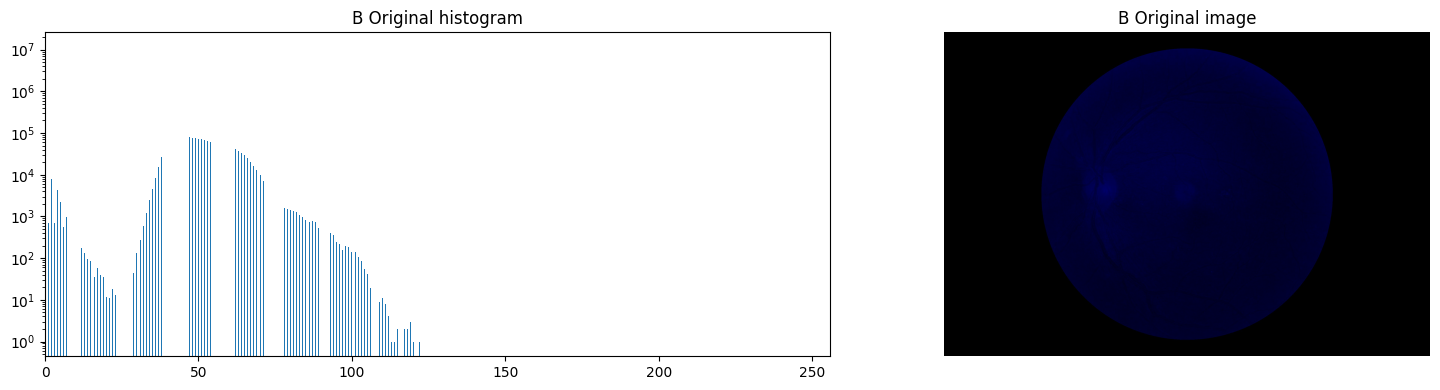

In [ ]:

# Original image
# load image here
orig_img = imread(r'/content/drive/MyDrive/ODIR/1015_left.jpg')

plot_image(orig_img, 'Original')
plot_hist_and_Channel_3(orig_img, 'Original')


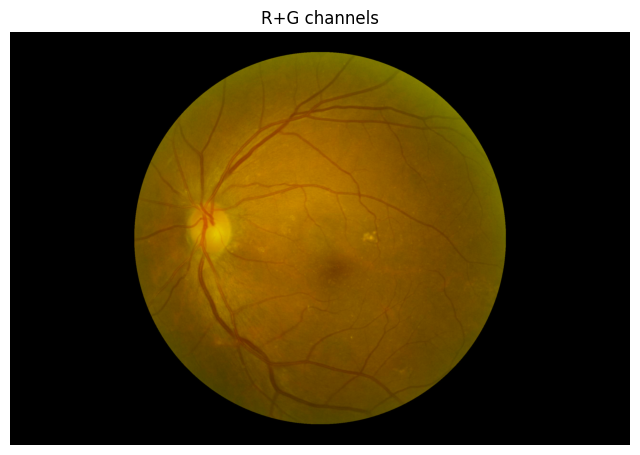

In [ ]:

# remove blue channel
rg_img = np.copy(orig_img)
rg_img[:,:,2] = np.zeros([rg_img.shape[0], rg_img.shape[1]], dtype=np.uint8)
plot_image(rg_img, 'R+G channels')


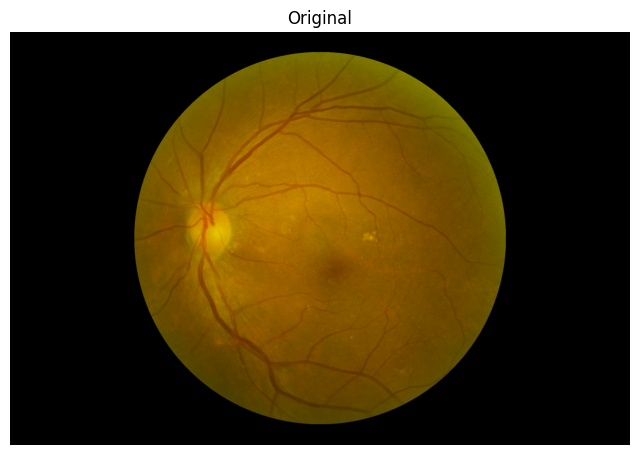

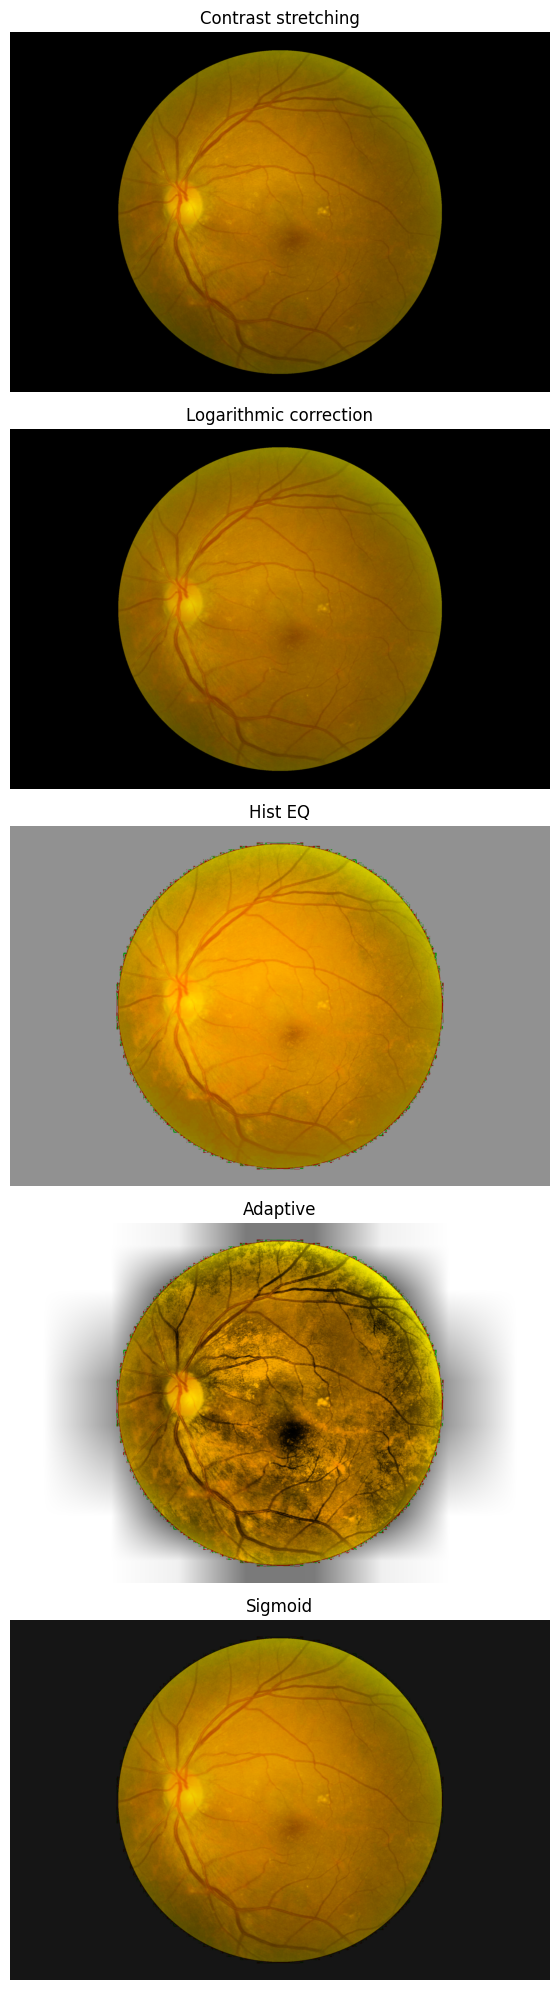

In [ ]:

# convert to HSV
hsv_img = rgb2hsv(rg_img)
# extract Hue channel
hue_img = hsv_img[:, :, 0]
# extract Saturation channel
sat_img = hsv_img[:, :, 1]
# extract Value channel
val_img = hsv_img[:, :, 2]

def correct_on_V_channel(H,S,normalized_V):
  norm_hsv = np.stack((H,S,normalized_V), axis=2)
  norm = hsv2rgb(norm_hsv)
  return util.img_as_ubyte(norm)

# Contrast stretching
pl, ph = np.percentile(val_img, (5, 100))
val_img_rescale = exposure.rescale_intensity(val_img, in_range=(pl, ph))
img_rescale = correct_on_V_channel(hue_img,sat_img,val_img_rescale)

# Logarithmic
val_logarithmic_corrected = exposure.adjust_log(val_img,1)
logarithmic_corrected = correct_on_V_channel(hue_img,sat_img,val_logarithmic_corrected)

# Hist EQ
val_img_eq = exposure.equalize_hist(val_img, nbins=512)
img_eq = correct_on_V_channel(hue_img,sat_img,val_img_eq)

# Adaptive Equalization
val_img_adapteq = exposure.equalize_adapthist(val_img, clip_limit=2.00)
img_adapteq = correct_on_V_channel(hue_img,sat_img,val_img_adapteq)

# Sigmoid
val_sigmoid = exposure.adjust_sigmoid(val_img, cutoff=0.4, gain=6, inv=False)
sigmoid = correct_on_V_channel(hue_img,sat_img,val_sigmoid)

plot_image(rg_img, 'Original')

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(20, 20))
ax1.imshow(img_rescale)
ax1.set_title("Contrast stretching")
ax1.axis('off')
ax2.imshow(logarithmic_corrected)
ax2.set_title("Logarithmic correction")
ax2.axis('off')
ax3.imshow(img_eq)
ax3.set_title("Hist EQ")
ax3.axis('off')
ax4.imshow(img_adapteq)
ax4.set_title("Adaptive")
ax4.axis('off')
ax5.imshow(sigmoid)
ax5.set_title("Sigmoid")
ax5.axis('off')
fig.tight_layout()


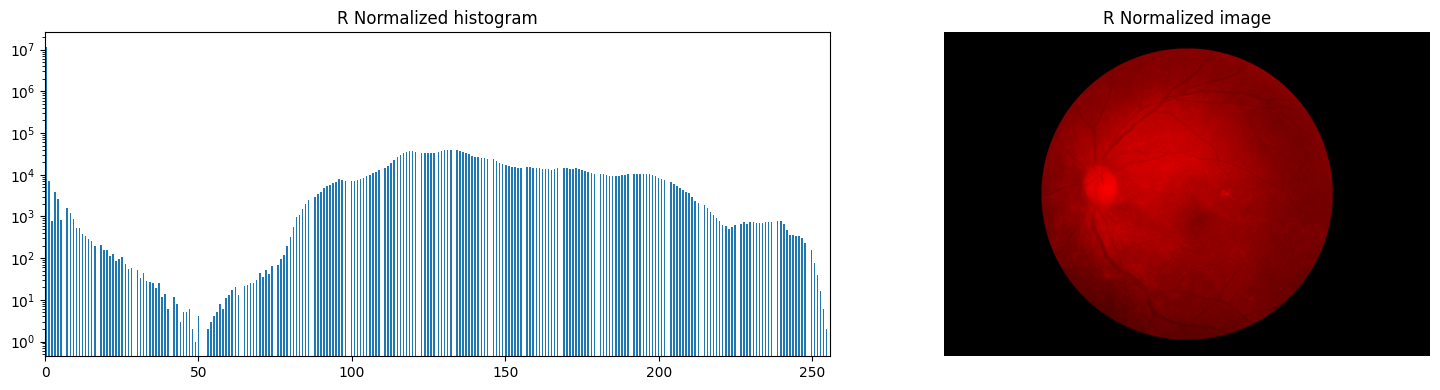

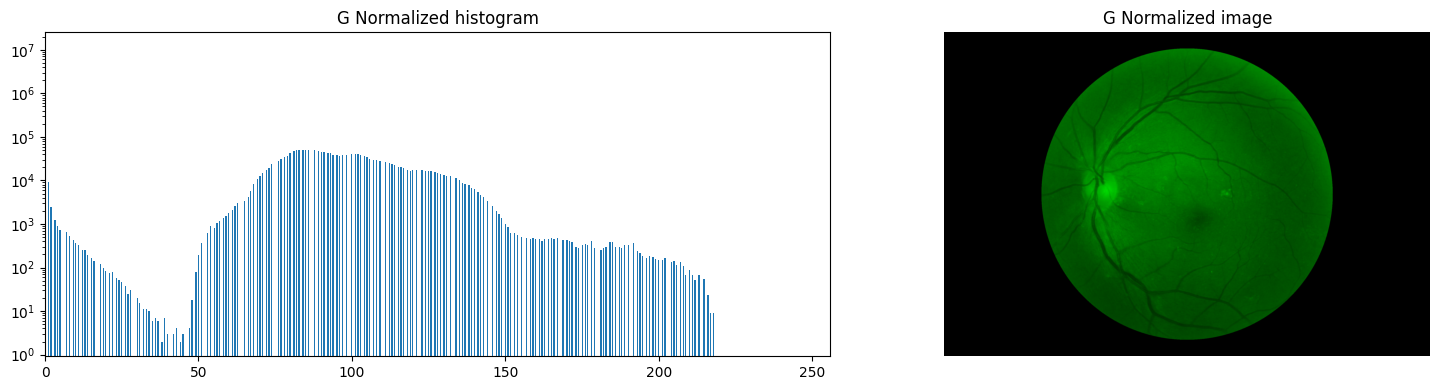

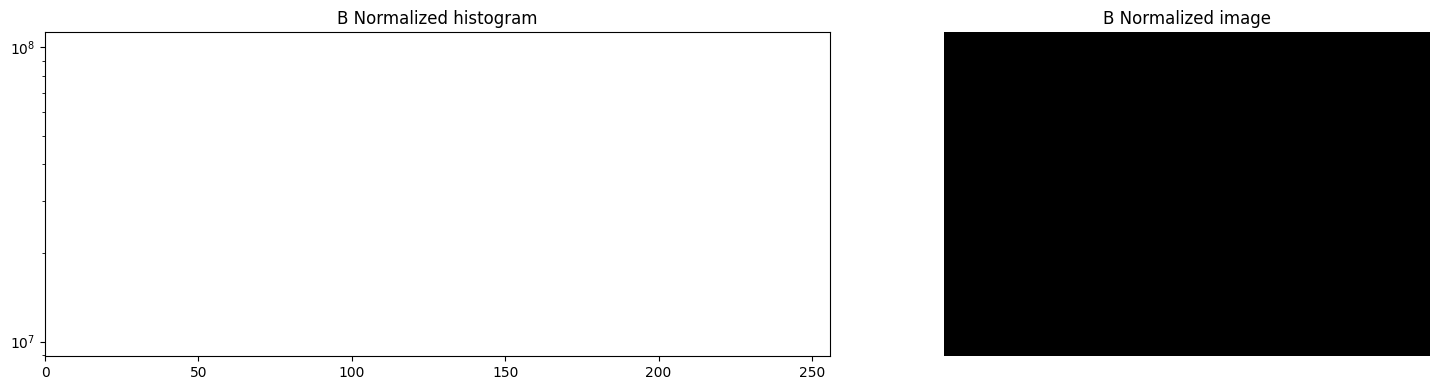

In [ ]:

norm_img = img_rescale

plot_hist_and_Channel_3(norm_img, 'Normalized')


In [ ]:

# convert to HSV
hsv_img = rgb2hsv(norm_img)
# extract Hue channel
hue_img = hsv_img[:, :, 0]
# extract Saturation channel
sat_img = hsv_img[:, :, 1]
# extract Value channel
val_img = hsv_img[:, :, 2]
# extract Red channel
r_img = norm_img[:, :, 0]
# extract Green channel
g_img = norm_img[:, :, 1]


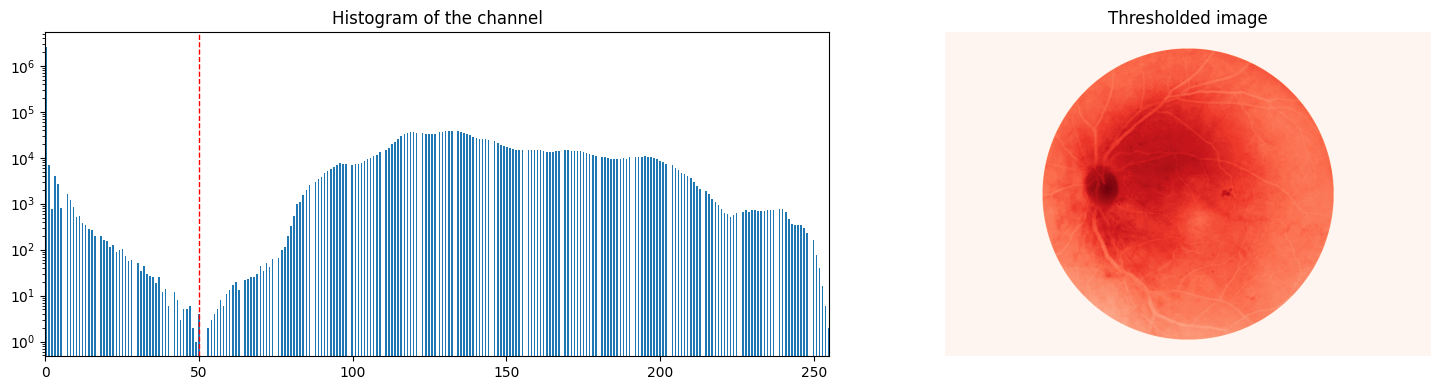

In [ ]:

r_img_e = extract_spectrum(r_img, 50, 256, map='Reds')


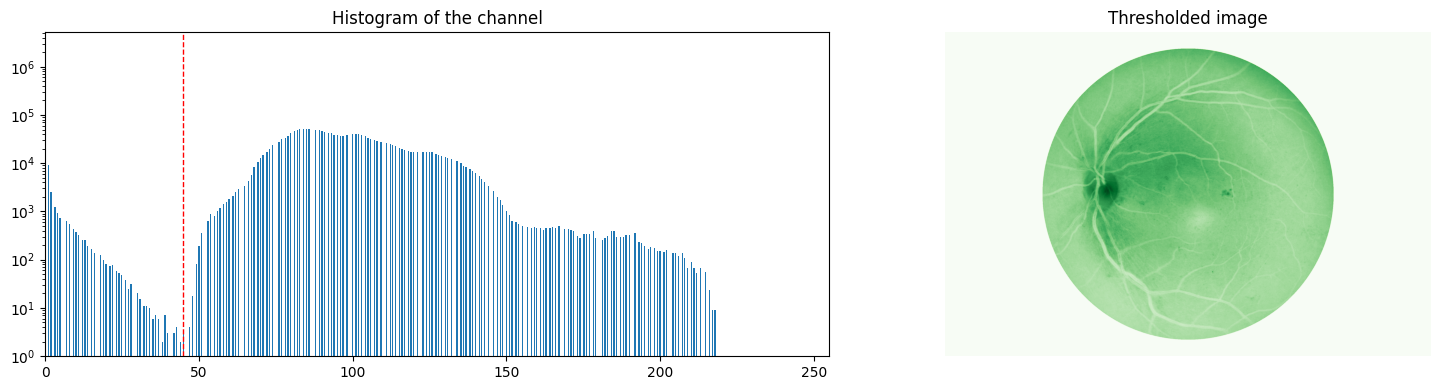

In [ ]:

g_img_e = extract_spectrum(g_img, 45, 256, map='Greens')


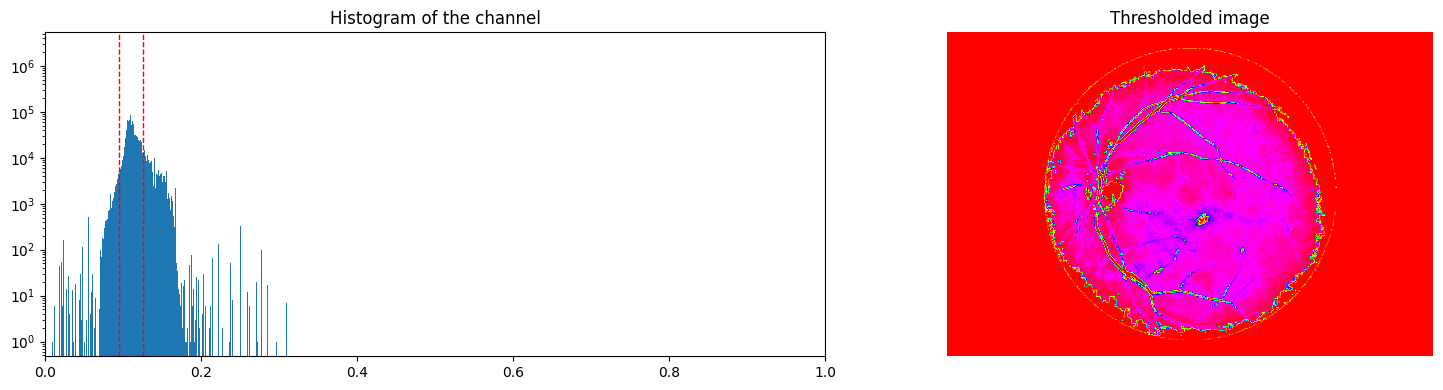

In [ ]:

hue_img_e = extract_spectrum(hue_img, 0.095, 0.125, dtype=float, map='hsv')


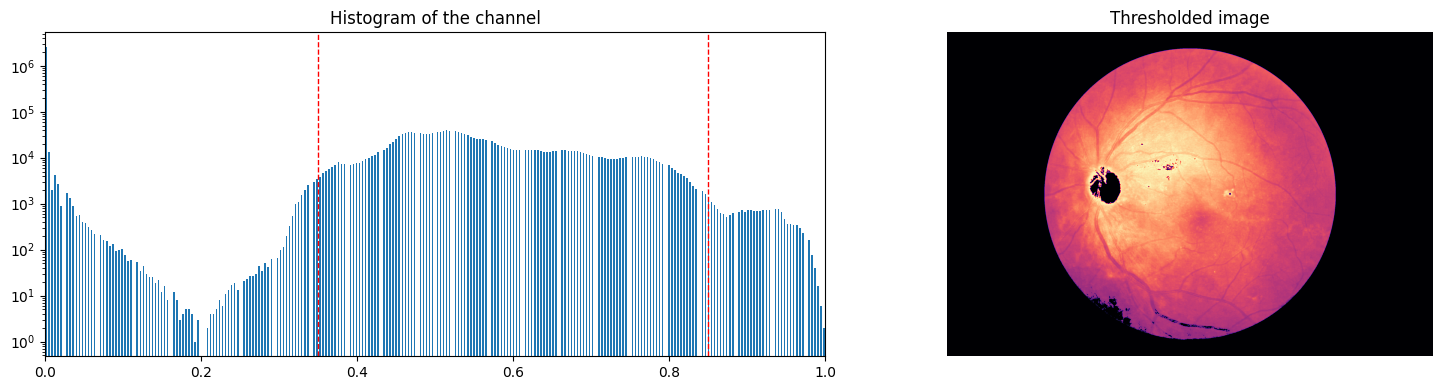

In [ ]:

val_img_e = extract_spectrum(val_img, 0.35, 0.85, dtype=float, map='magma')


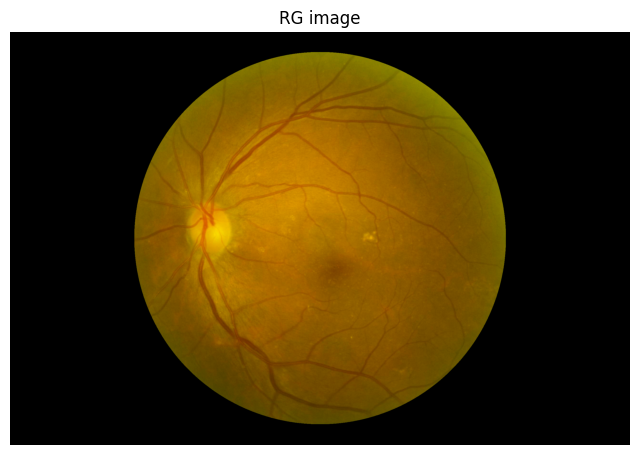

In [ ]:

# combine R+G channel
rg_img_e = np.stack((r_img_e,g_img_e,np.zeros([norm_img.shape[0], norm_img.shape[1]], dtype=np.uint8)), axis=2)
plot_image(rg_img_e, 'RG image')


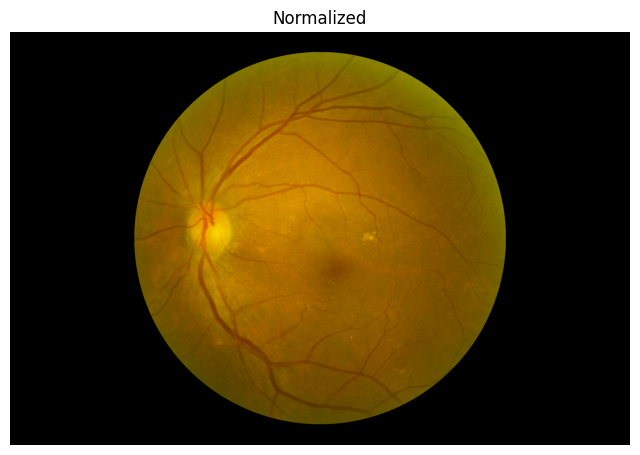

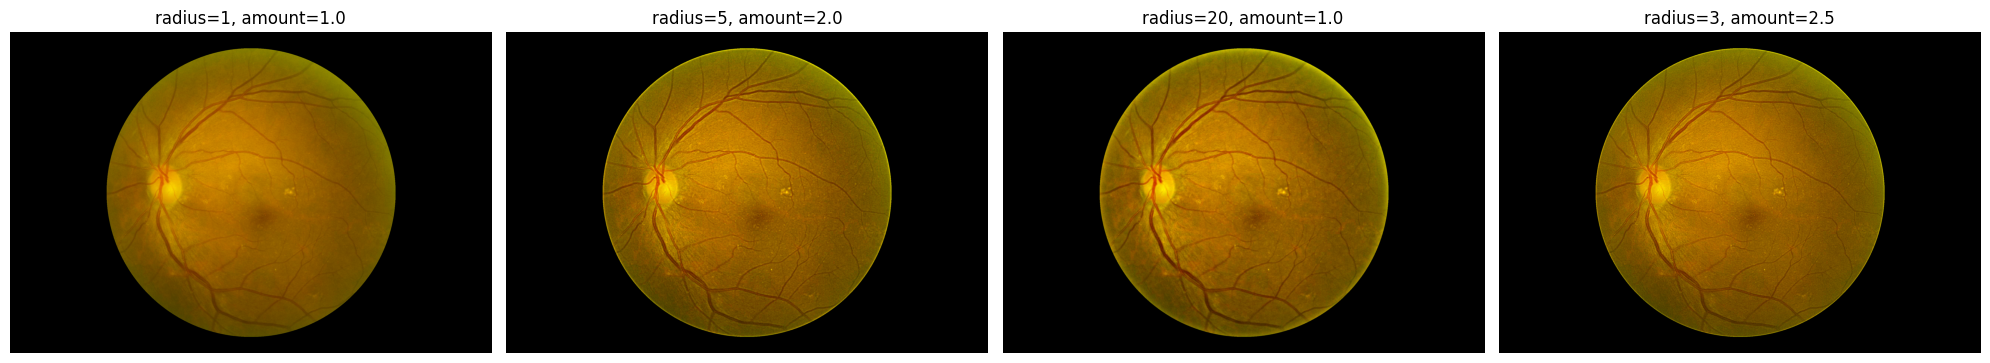

In [ ]:

norm_img = rg_img_e

result_1 = unsharp_mask(norm_img, radius=1, amount=1,  channel_axis=2)
result_2 = unsharp_mask(norm_img, radius=5, amount=2,  channel_axis=2)
result_3 = unsharp_mask(norm_img, radius=20,amount=1,  channel_axis=2)
result_4 = unsharp_mask(norm_img, radius=3, amount=2.5,channel_axis=2)

plot_image(norm_img, 'Normalized')

fig, axes = plt.subplots(ncols=4, figsize=(20, 20))
ax = axes.ravel()
ax[0].imshow(result_1)
ax[0].set_title('radius=1, amount=1.0')
ax[1].imshow(result_2)
ax[1].set_title('radius=5, amount=2.0')
ax[2].imshow(result_3)
ax[2].set_title('radius=20, amount=1.0')
ax[3].imshow(result_4)
ax[3].set_title('radius=3, amount=2.5')
for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()


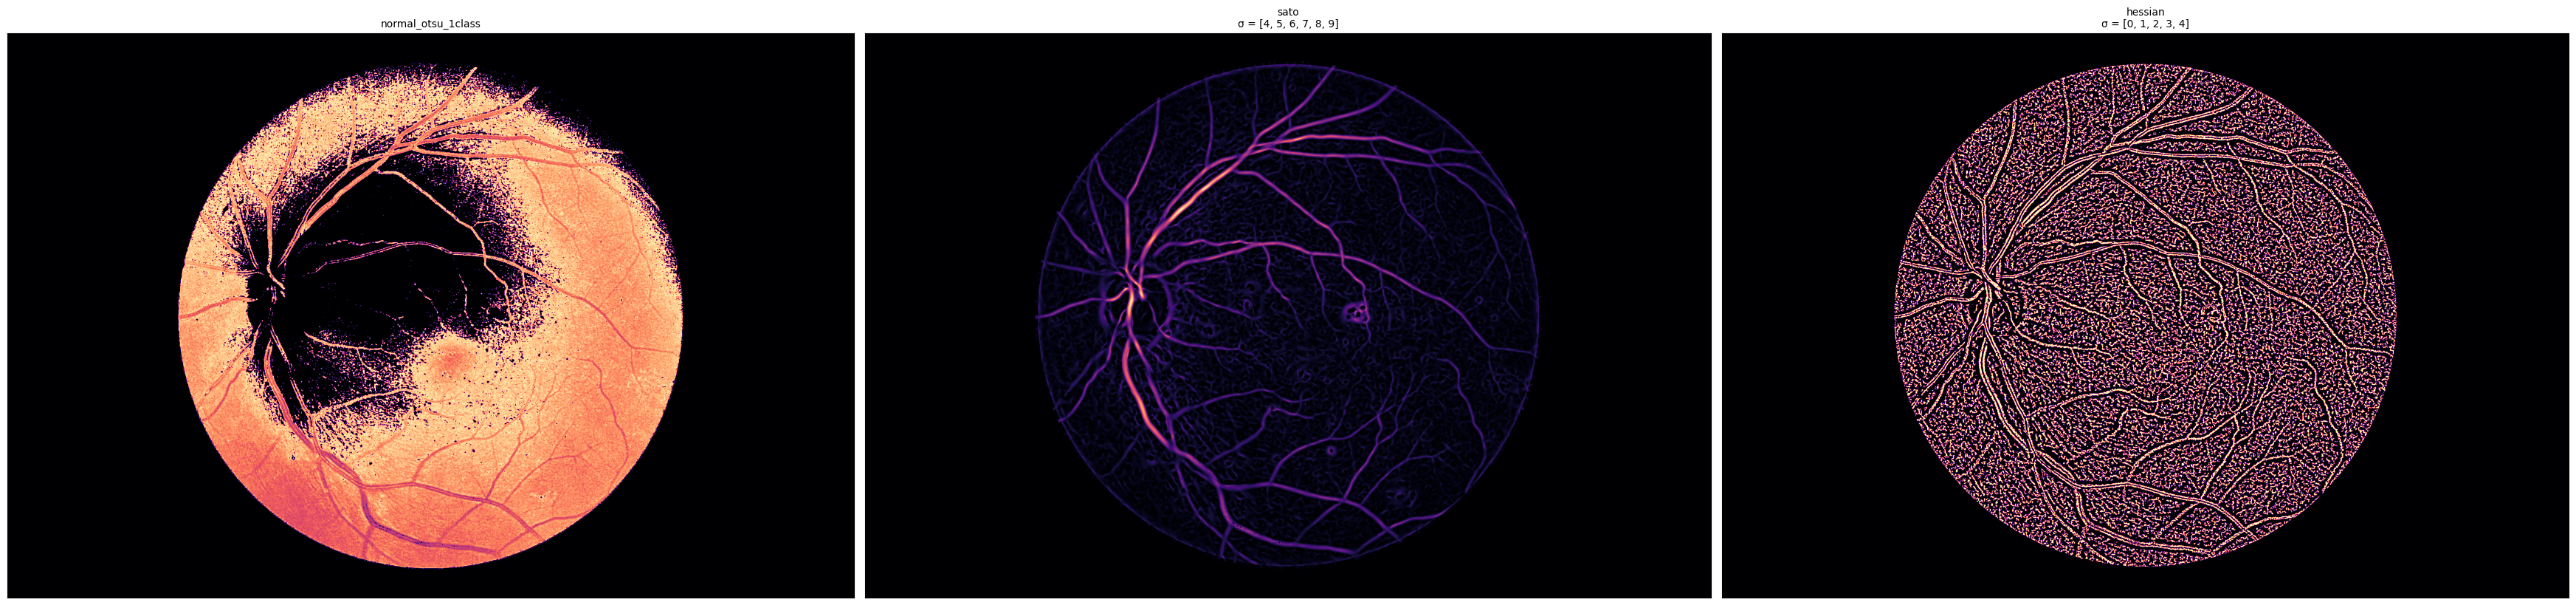

In [ ]:

def normal_otsu_1class(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

img_sharp = result_4
# convert the image to grayscale
img_sharp_gray = rgb2gray(img_sharp)

#x = int(img_sharp_gray.shape[1]/4)
#y = int(img_sharp_gray.shape[0]/4)
#img_sharp_gray = img_sharp_gray[y:3*y, 0:2*x]

# acquire otsu threshold
t0,t1 = threshold_multiotsu(img_sharp_gray, classes=3)
# mask image with otsu threshold
mask1 = (img_sharp_gray > t0)
mask2 = (img_sharp_gray > t0) & (img_sharp_gray < t1)

cmap = plt.cm.magma
plt.rcParams["axes.titlesize"] = "medium"
axes = plt.figure(figsize=(35, 35)).subplots(1, 3)

for i, (func, sigmas) in enumerate([
        (normal_otsu_1class, None),
        (sato,      range(4, 10)),
        (hessian,   range(0, 5 )),
      ]):

  br = True
  mask = mask1
  if (i>=2) : br = False
  if (i==0) : mask = mask2

  # use Sato filter to better distinguish the main vessels in the image
  result = func(img_sharp_gray, black_ridges=br, sigmas=sigmas) * mask

  axes[i].imshow(result, cmap=cmap)
  title = func.__name__
  if sigmas : title += f"\n\N{GREEK SMALL LETTER SIGMA} = {list(sigmas)}"
  axes[i].set_title(title)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()
